<a href="https://colab.research.google.com/github/jha-vineet69/Sentiment-Analysis-using-ULMFiT/blob/master/Sentiment_Analysis_with_ULMFiT_Fellowship_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Universal Language Model Fine-tuning for Text Classification</center>
## <center>NLP Sentimental Analysis on Twitter US Airlines Dataset</center>
### <center>By Vineet Jha</center>
<figure>
<center>
<img src='https://drive.google.com/uc?id=18b54q-IDrqe8yriY8exf5STBTs7AM8XG'/>
</center>
</figure>

# Abstract


Training on inductive transfer has significantly influenced computer vision, but current NLP methods often need task-specific modifications and training from scratch. This notebook discusses the performance of Universal Language Model Fine-tuning (ULMFiT) [1], and efficient transfer learning approach that can be applied to any NLP function, and implementing techniques that are essential to fine-tune a language model. Further, empirical results had been introduced after applying ULMFit for NLP sentimental analysis on Twitter US airlines dataset.

# Introduction

Text classification is a category of Natural Language Processing (NLP) tasks with real-world applications such as spam, fraud, and bot detection, emergency response, and commercial document classification, such as
for legal discovery. While Deep Learning models have achieved
state-of-the-art on many NLP tasks, these models
are trained from scratch, requiring large datasets,
and days to converge. Inductive transfer via fine-tuning has been unsuccessful for NLP. Dai and Le (2015) first proposed finetuning a language model (LM) but require millions of in-domain documents to achieve good performance, which severely limits its applicability. Also, LMs overfit to small datasets and suffered catastrophic forgetting when fine-tuned with a classifier.

Universal Language Model Fine-tuning (ULMFiT) addresses these
issues and enables robust inductive transfer learning for any NLP task, akin to fine-tuning ImageNet models.

# Model Description

The model used is the state-of-the-art language model AWD-LSTM \[2\], a
standard LSTM with various tuned dropout hyper-parameters (with no
input, short-cut links, or other sophisticated additions).

ULMFiT consists of three stages (Figure 1):

> a\) The LM is trained on a **general-domain** corpus to capture
> general features of the language in different layers.
>
> b\) The full LM is **fine-tuned** on target task data using
> discriminative fine-tuning ('Discr') and slanted triangular learning
> rates (STLR) to learn task-specific features.
>
> c\) The classifier is fine-tuned on the target task using **gradual
> unfreezing**, 'Discr', and STLR to preserve low-level representations
> and adapt high-level ones (shaded: unfreezing stages; black: frozen).

![picture](https://drive.google.com/uc?id=1yYnkPYHdtiHpqvaqBnIvdcf5XRYwP4nn)



## a) General-domain LM pretraining 

The model was pre-trained using Wikitext-103 which is consisting of
28,595 preprocessed Wikipedia documents and 103 million words.


## b) Target task LM fine-tuning 

Regardless of how complex the general-domain data used for pre-training is, the target task data would typically come from a different source. Therefore, we fine-tune the language model on target task results. This stage converges more quickly, provided a pre-trained general-domain LM, as it only needs to adjust to the idiosyncrasies of the target data, and it enables us to train a robust language model even for small datasets.


### i- Discriminative fine-tuning

Because different layers’ capture various information types, they should be fine-tuned to a different degree. Instead of using the same learning rate for all layers of the model, Discriminative fine-tuning allows one to apply specific learning levels to each layer. 
It was empirically found that it performed well to select the last layer's Alpha^L learning rate first by fine-tuning only the last layer and using Alpha^(L-1) = (Alpha^L)/2.6 as the lesser layer learning rate. For L, the order of the layer in the model.


### ii- Slanted triangular learning rates

To adjust its parameters to task-specific features, at the beginning of the training, make the model converge quickly into an acceptable region of the parameter space, and then refine its parameters. Slanted triangular learning rates (STLR), first increase the learning rate linearly and then decay it linearly. Finally, the learning rate at the stiffest slop will be chosen.

## c) Target task classifier fine-tuning


The pre-trained language model with two additional linear blocks was augmented to fine-tune the classifier. Following common practice for Computer Vision (CV) classifiers, each block uses batch normalization and dropout, with intermediate layer ReLU activations, and a Softmax activation that outputs a probability distribution at the last layer over target classes. Remember that the only parameters learned from scratch are the parameters in these task-specific classifier strata. The first linear layer takes the last hidden layer being pooled as the input state.


# Application

### a).  Dataset Description

The dataset is published on [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment), and it analyzes how travellers in February 2015 expressed their feelings on Twitter. It contains 14640 records, which was semantically analysed. 

### b). Problem Description

Sentiment analysis of the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets. The problem under our interest is to create a classification model that can identify the sentiment of the text written by the client as positive, negative or neutral.  

### Importing Libraries

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
import plotly.express as px
from plotly.offline import iplot

# Modeling, selection, and evaluation
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from pathlib import Path
path = Path.cwd()

In [3]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/jha-vineet69/Sentiment-Analysis-using-ULMFiT/master/data/Tweets.csv')
df_orig.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Data Preprocessing

In [4]:
data_classes = ["neutral", "positive", "negative"]
d = dict(zip(data_classes, range(0,3)))
df_orig['airline_sentiment'].map(d)
df = df_orig[['text','airline_sentiment']].copy()

In [5]:
df.to_csv(path/"df_cleaned.csv", index=False)

### Data Visualization

In [6]:
vals = [len(df[df['airline_sentiment']=='negative']['airline_sentiment']), len(df[df['airline_sentiment']=='positive']['airline_sentiment']), len(df[df['airline_sentiment']=='neutral']['airline_sentiment'])]
idx = ['negative', 'positive', 'neutral']
fig = px.pie(
    df,
    names='airline_sentiment',
    title='Target Value Distribution Chart',
    height=400,
    width=750
)
iplot(fig)

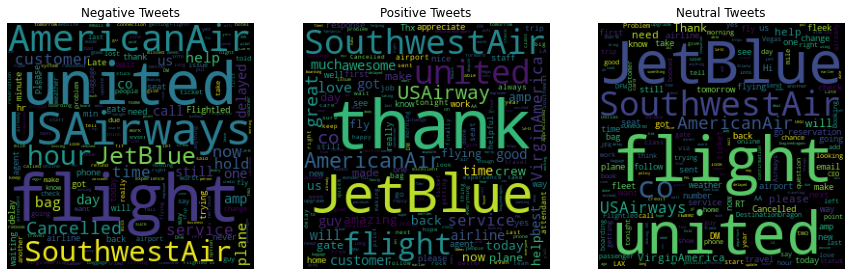

In [7]:
negative = " ".join(df[df['airline_sentiment'] == 'negative']['text'].to_list())
positive = " ".join(df[df['airline_sentiment'] == 'positive']['text'].to_list())
neutral = " ".join(df[df['airline_sentiment'] == 'neutral']['text'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ng_wlc = WordCloud(width=256, height=256, collocations=False).generate(negative)
ps_wlc = WordCloud(width=256, height=256, collocations=False).generate(positive)
ne_wlc = WordCloud(width=256, height=256, collocations=False).generate(neutral)
wcs = [ng_wlc, ps_wlc, ne_wlc]
titls = ["Negative Tweets", "Positive Tweets", "Neutral Tweets"]

for num, el in enumerate(wcs):
    ax[num].imshow(el)
    ax[num].axis('off')
    ax[num].set_title(titls[num])

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


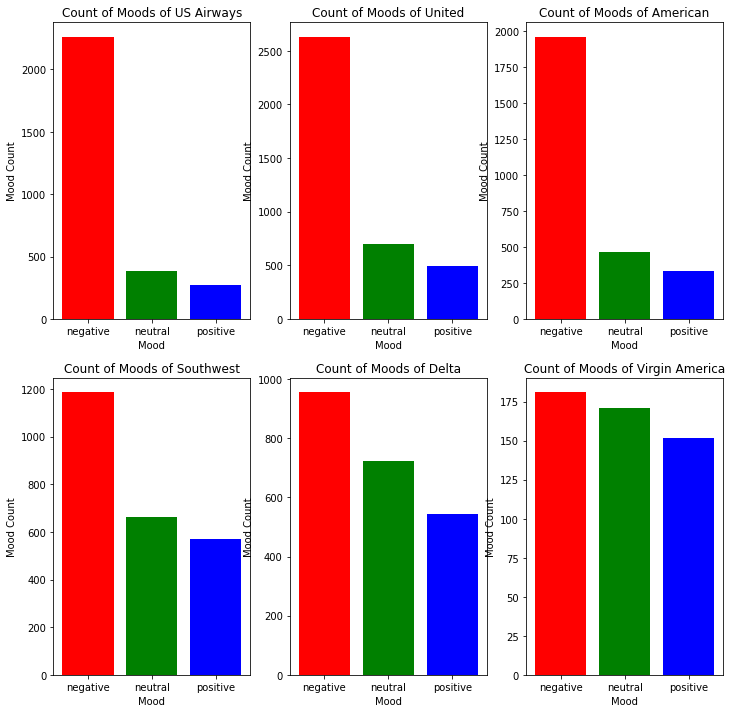

In [8]:
print("Total number of tweets for each airline \n ",df_orig.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df_orig[df_orig['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

### Working with ULMFiT

In [9]:
data_lm = TextLMDataBunch.from_csv(path, 'df_cleaned.csv', label_cols=['airline_sentiment'], text_cols=['text'])

In [10]:
data_lm.save('data_lm_export.pkl')

In [11]:
data_clas = TextClasDataBunch.from_csv(path, 'df_cleaned.csv', vocab=data_lm.train_ds.vocab, bs = 32, label_cols=['airline_sentiment'], text_cols=['text'])

In [12]:
data_clas.save('data_clas_export.pkl')

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


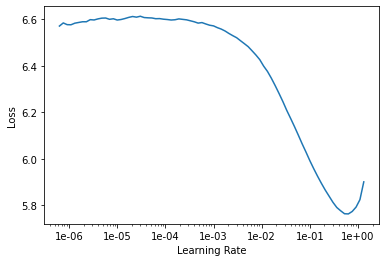

In [14]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [15]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.714449,4.067479,0.249028,00:22


In [16]:
learn.save('fit_head')
learn.load('fit_head');

In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.964367,3.830896,0.280186,00:28
1,3.806874,3.714764,0.290034,00:28
2,3.565395,3.655663,0.297965,00:28
3,3.314178,3.665454,0.298831,00:28
4,3.130360,3.683629,0.298267,00:28


In [18]:
learn.save_encoder('fine_tuned_enc')

### Data Classifier

In [19]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united xxmaj why do i still not have my bags ? xxmaj they arrived xxup xxunk & & website says they 're still at the airport .. 2 1 / 2 hours xxmaj late xxmaj flightr ? ? ? ! ! # nothappy,negative
xxbos @americanair xxmaj in car gng to xxup dfw . xxmaj pulled over 1hr ago - very icy roads . xxmaj on - hold with xxup aa since 1hr . xxmaj ca n't reach xxunk for xxup xxunk . xxmaj wat 2 do ?,negative
"xxbos @southwestair "" xxmaj will my luggage be on that flight ? "" "" xxmaj no "" "" y not "" "" bc ur on that flight n it wo n't end up where ur goin http : / / t.co / xxunk",negative
xxbos @southwestair better travel photos : \n xxmaj my xxmaj kindle e - book xxmaj easy xxmaj xxunk guide http : / / t.co / xxunk m : \n http : / / t.co / xxunk http : / / t.co / xxunk,neutral


In [20]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [21]:
learn.load_encoder('fine_tuned_enc')
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


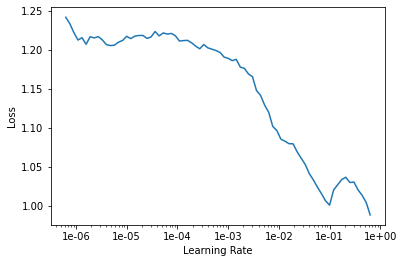

In [22]:
learn.lr_find()
learn.recorder.plot(skip_end = 10)

In [23]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.663617,0.533235,0.784568,00:21


In [24]:
learn.save('first')
learn.load('first');

In [25]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.615179,0.503715,0.797542,00:24


In [26]:
learn.save('second')
learn.load('second');

In [27]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.584819,0.462851,0.820417,00:36


In [28]:
learn.save('third')
learn.load('third');

In [29]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.483286,0.457690,0.822124,00:47
1,0.456223,0.460483,0.823831,00:47
2,0.387978,0.463345,0.823148,00:50
3,0.344398,0.460185,0.825879,00:47
4,0.331299,0.464445,0.826903,00:46


In [30]:
learn.save('final')

### Evaluate Results

In [31]:
y_pred, y_true = learn.get_preds()

In [32]:
y_pred = np.argmax(y_pred, axis=1)

In [33]:
y_pred[0:20]

tensor([0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0])

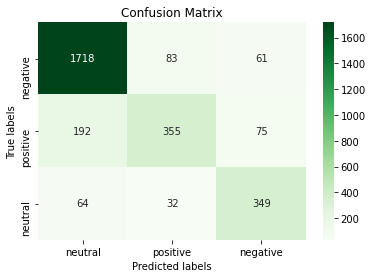

In [34]:
cm = confusion_matrix(y_true, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt='d'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(data_classes); 
ax.yaxis.set_ticklabels(reversed(data_classes));

In [35]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1862
           1       0.76      0.57      0.65       622
           2       0.72      0.78      0.75       445

    accuracy                           0.83      2929
   macro avg       0.78      0.76      0.77      2929
weighted avg       0.82      0.83      0.82      2929



# Conclusion
By the conclusion, we have applied a ULMFiT on classification job for US airlines sentimental analysis where the obtained results are promising. Using transfer learning and AWD-LSTM pre-trained network we reach an accuracy of more than 82% with few learning epochs, which is pretty good compared to the literature results. 

# Further Improvements
The results can be improved by pre-training the model with text chats from social networks e.g. Twitter, Facebook, where non-formal language can more accurately fit this dataset compared to Wikitext-103, which in most cases contain a formal and scientific language.



Also, more data can be scraped from Twitter to increase data corpus.

Besides the data is highly dominated by negative tweets and is highly imbalanced. Thus our model is overfitting on it. We can use Resampling Techniques like SMOTE to get better results.

# References


\[1\] Jeremy Howard and Sebastian Ruder, "Universal language model fine-tuning for
text classification," in *ACL 2018 - 56th Annual Meeting of the
Association for Computational Linguistics, Proceedings of the Conference:* https://arxiv.org/abs/1801.06146
(Long Papers), 2018. <br>

\[2\] "Twitter US Airline Sentiment
\| Kaggle." \[Online\]. Available:
https://www.kaggle.com/crowdflower/twitter-airline-sentiment.

\[3\] "Practical Deep Learning for Coders" Available: https://course.fast.ai/